# Parlament

> Using recommender systems to study voting patterns in the Swiss government. This work was done during the [DataJam Days](datajamdays.org) at EPFL (Nov 24-25th 2017).

This notebook holds the main contributions of our work.

---

#### Authors

* Dylan Bourgeois ([@dtsbourg](https://twitter.com/dtsbourg))
* Lazare Girardin (@lazareGirardin)
* Louis Duvigneau (@loduv)

#### License

This work is licensed under [GPL v3](https://www.gnu.org/licenses/gpl.html)


In [1]:
# Import libraries
# Make sure you have installed the requirements
import requests
import json
import pandas as pd
import scipy as sc
import numpy as np
import matplotlib.pyplot as plt

# Some useful options
%matplotlib inline
plt.style.use('ggplot')
savefig = False # used to generate figures

In [2]:
# Import utilities
import sys
sys.path.insert(0, '../lib')
from masterscrap import masterscrap, fetch_councillor, fetch_factions

## Data extraction

We start by extracting the data from [our source](http://ws-old.parlament.ch/).

We need the data for 4 of the main political parties (denoted as *factions*). Visit the [README](https://github.com/lazareGirardin/DataJamDays/blob/master/README.md) for more details on the data.

In [3]:
PLR   = 1
UDC   = 2
PS    = 4
VERTS = 6
list_factions = [PLR, UDC, PS, VERTS]

In [4]:
# Create the request and download the data
total_list = {}; party_dict = {}; reverse_idx_party_dict = {}
for id_ in list_factions:
    r = fetch_factions(id_)
    if r.status_code != requests.codes.ok:
        print("Could not fetch faction {}".format(id_))
        break
    j = r.json()
    dict_ = {member['firstName'] + " " + member['lastName'] : member['number'] for member in j['members']}
    partyy = {member['number'] : id_ for member in j['members']}
    reverse_idx_party_dict[id_] = [member['number'] for member in j['members']]
    party_dict.update(partyy)
    total_list.update(dict_)

In [5]:
print("Fetched {} councillors from {} factions :".format(len(total_list), len(list_factions)))
for i in list_factions:
    print("\t * Faction {} : {} councillors".format(i, len(reverse_idx_party_dict[i])))

Fetched 187 councillors from 4 factions :
	 * Faction 1 : 45 councillors
	 * Faction 2 : 55 councillors
	 * Faction 4 : 74 councillors
	 * Faction 6 : 13 councillors


We can now get the voting history for these councillors. We limit the search to 5 pages of results if they have a large voting history. 

> Note that this doesn't have to be run as the data has already been collected. It can be read statically from a pickle file.

In [6]:
#nb_pages = 5
#df = masterscrap(total_list , nb_pages)

In [7]:
df = pd.read_pickle("../data/parlement_votes_5pages.pkl")

### Extracting a graph structure

The first analysis conducted was to draw a graph with the selected councillors and their votes.

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_graph(graph, df):
    # extract nodes from graph
    nodes = set([n1 for n1, n2 in graph] + [n2 for n1, n2 in graph])

    # create networkx graph
    G=nx.Graph()
    G.position = {}

    # add nodes
    for node in nodes:
        G.add_node(node)

    # add edges
    for edge in graph:
        G.add_edge(edge[0], edge[1])

    
    # draw graph
    pos=nx.spring_layout(G)
    color_map = []
    ids = df.columns.values
    for node in G:
        if node in ids:
            color_map.append('blue')
        else: 
            color_map.append('green')  
    nx.draw(G, pos, node_color=color_map)

    # show graph
    plt.show()

In [9]:
# Utility
flatten = lambda l: [item for sublist in l for item in sublist]

In [10]:
# draw example
edges = []
for c in df:
    votes = df[c]
    edges += [(c, id_) for id_ in df.index.tolist() if votes.loc[id_] == 'Yes']

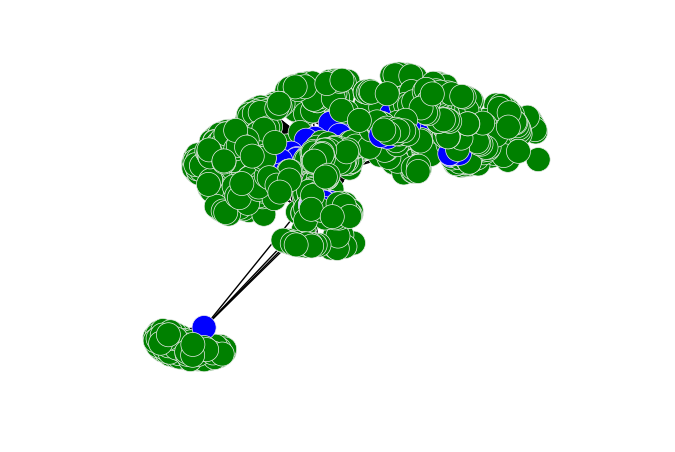

In [11]:
# draw example
draw_graph(edges, df)

### Matrix Factorisation

We now begin the "Recommender System" part of our analysis. We will be using scikit-learn to use Non Negative Matrix Factorisation techniques. This involves encoding the different voting states to real numbers, then factorising our model.

In [12]:
from sklearn.decomposition import NMF

In [13]:
# Voting behaviour dictionary
vote_encoding = {
    'Yes' : 2, 
    'No'  : 1, 
    'P'   : 0, 
    'EH'  : 0, 
    'ES'  : 0, 
    'NT'  : 0
}

In [14]:
# encoding the voting states
clean_df = df.replace(vote_encoding)
clean_df = clean_df.fillna(0)
clean_df

,3055,2670,2758,2796,2584,3057,2772,2372,2740,3062,...,3068,3072,2685,3003,2569,3051,3086,3000,2654,2710
17496,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,...,2.0,2.0,2.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0
17983,2.0,0.0,2.0,2.0,0.0,2.0,2.0,0.0,2.0,2.0,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
17209,2.0,0.0,2.0,2.0,0.0,2.0,2.0,0.0,0.0,2.0,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
16362,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,2.0,2.0,0.0,2.0,0.0,2.0,2.0,2.0,0.0,0.0
17533,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,2.0,2.0,0.0,2.0,0.0,2.0,2.0,2.0,0.0,0.0
17534,2.0,0.0,2.0,2.0,0.0,2.0,2.0,0.0,0.0,2.0,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
17815,2.0,0.0,2.0,2.0,0.0,2.0,2.0,0.0,0.0,2.0,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
17816,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,2.0,2.0,0.0,2.0,0.0,2.0,2.0,2.0,0.0,0.0
17910,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,2.0,2.0,0.0,2.0,0.0,2.0,2.0,2.0,0.0,0.0
17911,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,2.0,2.0,0.0,2.0,0.0,2.0,2.0,2.0,0.0,0.0


In [15]:
# Some of the councillors don't have a voting record, so we discard them
intersection = [i for i in clean_df.columns if i in total_list.values()]

good_dict = {k: v for k, v in total_list.items() if v in intersection}
print("{} councillors have a voting record.".format(len(good_dict)))

170 councillors have a voting record.


We now run NMF.

#### NMF - 2 components

We factorise the matrix into a 2D latent space, which has low representational abilities but is useful for plotting.

In [16]:
model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(clean_df)
H = model.components_

In [17]:
print("H : ", H.shape)
print("W : ", W.shape)

H :  (2, 170)
W :  (1718, 2)


We can now plot our model in the latent space.

In [18]:
# A useful colormap
color_dict = {
    UDC : 'chocolate', 
    PS  : 'red', 
    PLR :'blue', 
    VERTS :'green'
}

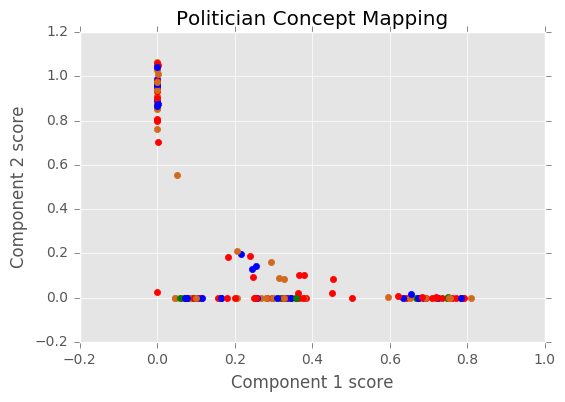

In [19]:
plt.figure(1)
plt.title("Politician Concept Mapping")

plt.xlabel("Component 1 score")
plt.ylabel("Component 2 score")

for i,c in enumerate(good_dict):
    plt.scatter(H[0,:][i], H[1,:][i], color=color_dict[party_dict[good_dict[c]]])

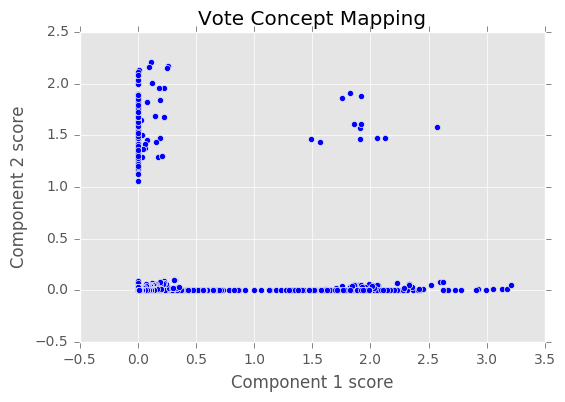

In [20]:
plt.title("Vote Concept Mapping")

plt.scatter(W[:,0],W[:,1])
plt.xlabel("Component 1 score")
plt.ylabel("Component 2 score")

plt.show()

#### NMF - 150 components

We now move to a 150 dimensional latent space.

In [21]:
model = NMF(n_components=150, init='random', random_state=0)
W = model.fit_transform(clean_df)
H = model.components_

In [22]:
print("H : ", H.shape)
print("W : ", W.shape)

H :  (150, 170)
W :  (1718, 150)


We can measure the reconstruction error :

In [23]:
from sklearn.metrics import mean_squared_error

nR = np.dot(W,H)
mse = mean_squared_error(clean_df.values.flatten(), list(nR.flatten()))
print("Reconstruction error is", mse*100, "%")

Reconstruction error is 0.211063923528 %


As we can't plot a 150 dimensional space we rely on t-SNE to yield a manageable represenation in 2D.

In [24]:
from sklearn.manifold import TSNE

In [25]:
W_embedded = TSNE(n_components=2).fit_transform(W)
H_embedded = TSNE(n_components=2).fit_transform(H)

In [26]:
print("t-SNE(H) : ", H_embedded.shape)
print("t-SNE(W) : ", W_embedded.shape)

t-SNE(H) :  (150, 2)
t-SNE(W) :  (1718, 2)


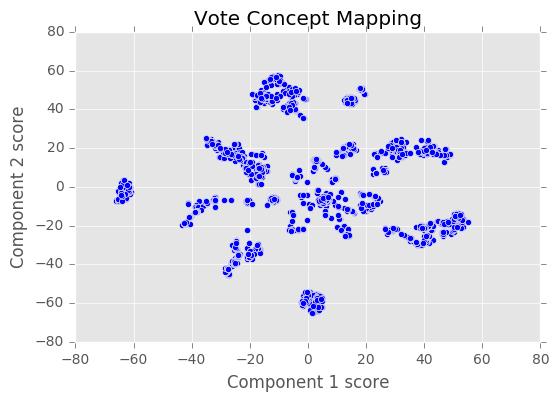

In [27]:
plt.figure(1)
plt.title("Vote Concept Mapping")

plt.xlabel("Component 1 score")
plt.ylabel("Component 2 score")

plt.scatter(W_embedded[:,0], W_embedded[:,1])
if savefig == True:
    plt.savefig('../img/Global_Vote_map.png')

We now must compute the discrepencies in voting behavior within parties.

**TODO** The unity percentage can be represented as an alpha.

In [28]:
def get_yes_votes(df, party):
    return (df[party][df[party] == vote_encoding['Yes']].count(axis=1) > 0)

In [29]:
abc_df = clean_df.rename(columns=party_dict)

voter_pattern_df = pd.DataFrame()
voter_pattern_df['UDC'] = get_yes_votes(abc_df, UDC)
voter_pattern_df['PS'] = get_yes_votes(abc_df, PS)
voter_pattern_df['PLR'] = get_yes_votes(abc_df, PLR)
voter_pattern_df['Verts'] = get_yes_votes(abc_df, VERTS)

voter_pattern_df = voter_pattern_df.astype(int)

### Party-wise voting behaviour

In [30]:
# color mapping
# blue : No
# green : Yes
color_dict = {
    0 : 'blue',
    1 : 'green'
}

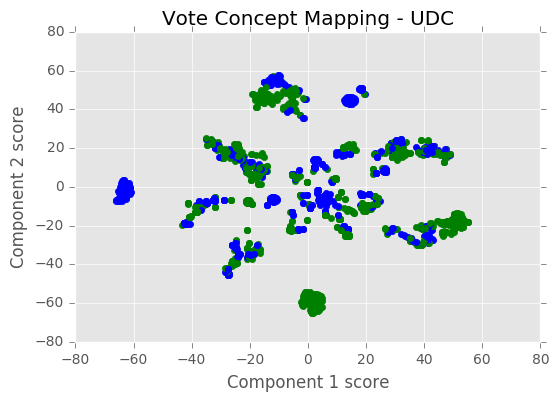

In [31]:
# Example : UDC
plt.figure(1)
plt.title("Vote Concept Mapping - UDC")

plt.xlabel("Component 1 score")
plt.ylabel("Component 2 score")

for i,c in enumerate(voter_pattern_df['UDC']):
    plt.scatter(W_embedded[:,0][i], W_embedded[:,1][i], color=color_dict[voter_pattern_df['UDC'].iloc[i]])
if savefig == True:
    plt.savefig('../img/UDC_votes.png')

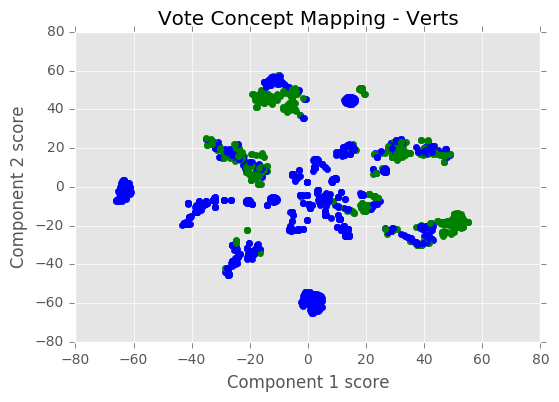

In [32]:
# Example : Verts
plt.figure(1)
plt.title("Vote Concept Mapping - Verts")

plt.xlabel("Component 1 score")
plt.ylabel("Component 2 score")

for i,c in enumerate(voter_pattern_df['Verts']):
    plt.scatter(W_embedded[:,0][i], W_embedded[:,1][i], color=color_dict[voter_pattern_df['Verts'].iloc[i]])
if savefig == True:
    plt.savefig('../img/Verts_votes.png')

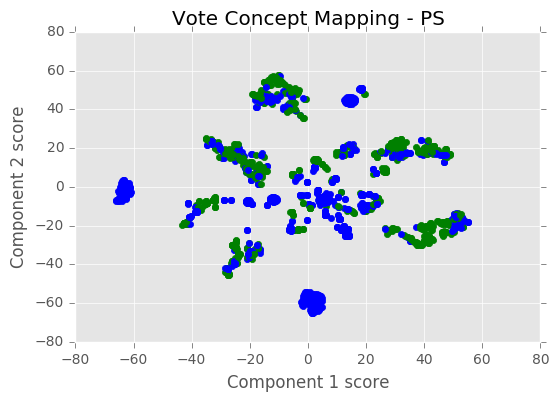

In [33]:
# Example : PS
plt.figure(1)
plt.title("Vote Concept Mapping - PS")

plt.xlabel("Component 1 score")
plt.ylabel("Component 2 score")

for i,c in enumerate(voter_pattern_df['PS']):
    plt.scatter(W_embedded[:,0][i], W_embedded[:,1][i], color=color_dict[voter_pattern_df['PS'].iloc[i]])
if savefig == True:
    plt.savefig('../img/PS_votes.png')

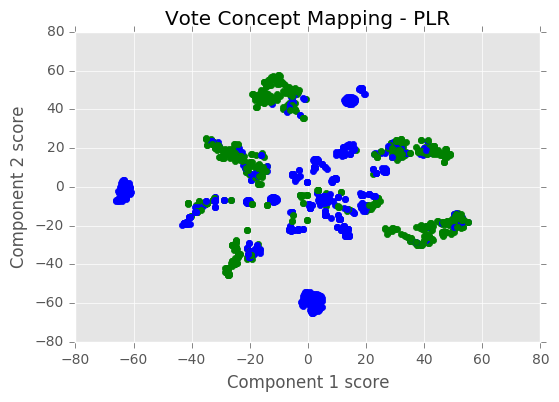

In [34]:
# Example : PLR
plt.figure(1)
plt.title("Vote Concept Mapping - PLR")

plt.xlabel("Component 1 score")
plt.ylabel("Component 2 score")

for i,c in enumerate(voter_pattern_df['PLR']):
    plt.scatter(W_embedded[:,0][i], W_embedded[:,1][i], color=color_dict[voter_pattern_df['PLR'].iloc[i]])
if savefig == True:
    plt.savefig('../img/PLR_votes.png')

### Voting pattern discrepencies between parties

We can now compare the voting behaviours pairwaise for each party.

In [35]:
# Color mapping
# black : agree
# red : disagree
color_dict = {
    0 : 'black',
    1 : 'red'
}

In [36]:
def insert_voting_disagreement(df, party1, party2):
    vs_key = party1+'/'+party2
    if vs_key not in df.keys():
        df[vs_key] = abs(voter_pattern_df[party1] - voter_pattern_df[party2])
    return df

In [37]:
voter_pattern_df = insert_voting_disagreement(voter_pattern_df, 'UDC', 'Verts')
voter_pattern_df

,UDC,PS,PLR,Verts,UDC/Verts
17496,1,0,1,1,0
17983,0,1,1,0,0
17209,0,1,1,0,0
16362,1,0,1,1,0
17533,1,0,1,1,0
17534,0,1,1,0,0
17815,0,1,0,0,0
17816,1,0,1,1,0
17910,1,0,1,1,0
17911,1,0,1,1,0


In [38]:
voter_pattern_df = insert_voting_disagreement(voter_pattern_df, 'PS', 'Verts')
voter_pattern_df

,UDC,PS,PLR,Verts,UDC/Verts,PS/Verts
17496,1,0,1,1,0,1
17983,0,1,1,0,0,1
17209,0,1,1,0,0,1
16362,1,0,1,1,0,1
17533,1,0,1,1,0,1
17534,0,1,1,0,0,1
17815,0,1,0,0,0,1
17816,1,0,1,1,0,1
17910,1,0,1,1,0,1
17911,1,0,1,1,0,1


We can now plot their differences.

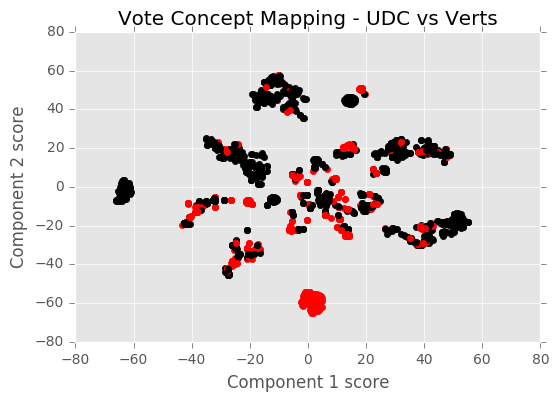

In [39]:
plt.figure(1)
plt.title("Vote Concept Mapping - UDC vs Verts")
x = W_embedded[0,:]
y = W_embedded[1,:]

plt.xlabel("Component 1 score")
plt.ylabel("Component 2 score")

for i,c in enumerate(voter_pattern_df['UDC/Verts']):
    plt.scatter(W_embedded[:,0][i], W_embedded[:,1][i], color=color_dict[voter_pattern_df['UDC/Verts'].iloc[i]])
if savefig == True:
    plt.savefig('../img/UDC_vs_Verts_votes.png')

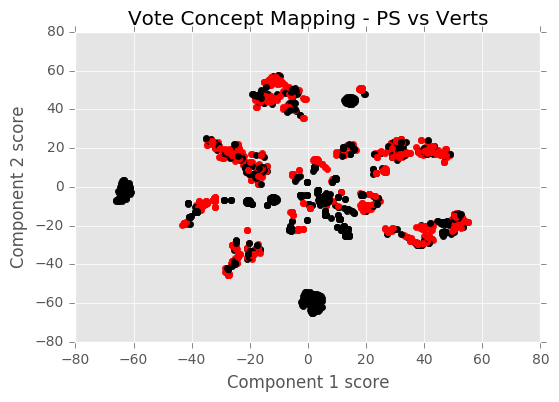

In [40]:
plt.figure(1)
plt.title("Vote Concept Mapping - PS vs Verts")

plt.xlabel("Component 1 score")
plt.ylabel("Component 2 score")

for i,c in enumerate(voter_pattern_df['PS/Verts']):
    plt.scatter(W_embedded[:,0][i], W_embedded[:,1][i], color=color_dict[voter_pattern_df['PS/Verts'].iloc[i]])
if savefig == True:
    plt.savefig('../img/PS_vs_Verts_votes.png')